In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import parquet
import os

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from os import mkdir, listdir
from os.path import join
import numpy as np
from pickle import load, dump


pd.set_option('display.max_columns', 200)

In [2]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
filename = pd.read_csv(r"C:\Users\tyler\OneDrive\Desktop\PhD Stuff\STA 6366\Final Project\FinalData.csv")

In [4]:
def addStats(stats, name, var):
    stats[name + "_median"] = var.median()
    stats[name + "_iqr"] = var.astype(np.float64).quantile(.75) - var.astype(np.float64).quantile(.25)

def getStats(X_train, X_test):
    stats = {}
    addStats(stats, "X_train", X_train)
    addStats(stats, "X_test", X_test)
    
    return stats

    
def get_train_environment(n_splits = 20, filename = r"C:\Users\tyler\OneDrive\Desktop\PhD Stuff\STA 6366\Final Project\FinalData.csv", seed=4321):
    cachedFolds = False
    cachedData = False
    # If you wish to delete the cache, please delete the entire cache folder
    if "cache" in listdir():
        cachedData = True
        if str(n_splits) + ".pickle" in listdir("cache"):
            print("Found cached folds, using those")
            cachedFolds = True
        else:
            print("No cached folds found, generating new folds.")
    else:
        print("No cache found, generating holdout set and folds.")
    
    if cachedData == False:
        data = None
        try:
            data = pd.read_csv(filename)
            data = data.drop("Unnamed: 0", axis=1)
        except:
            print(f"Error, unable to read file {filename}, you can provide the filename via filename = <filename>")
            exit()
        
        data = data.drop(["Name", "appid"], axis=1)

        pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())])

        X = data.drop("ln.pricep1", axis=1)
        y = data["ln.pricep1"]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, test_size=0.05)

        X_train_scaled = pipeline.fit_transform(X_train)
        X_test_scaled = pipeline.fit_transform(X_test)
        
        # Needed to reverse the scaling
        stats = getStats(X_train, X_test)

        mkdir("cache")

        with open(join("cache", "stats_X_scaled.pickle"), 'wb') as file:
            dump([stats, X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test], file)

        yield stats, X_train_scaled, X_test_scaled, y_train, y_test

        if n_splits == 20:
            print(f"Using default n_splits = {20}, please change depending on what problem you are solving.")

        kf = KFold(n_splits=n_splits)

        toDump = []

        i = 0
        for train_index, test_index in kf.split(X_train, y_train):
            X_folded_train = X_train.iloc[train_index]
            y_folded_train = y_train.iloc[train_index]
            X_folded_test = X_train.iloc[test_index]
            y_folded_test = y_train.iloc[test_index]
            stats = getStats(X_folded_train, X_folded_test)

            X_folded_train_scaled = pipeline.fit_transform(X_folded_train)
            X_folded_test_scaled = pipeline.fit_transform(X_folded_test)

            toDump.append((i, stats, (X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test)))
            yield i, stats, X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test
            i += 1
        
        print("Dumping KFolds, do not quit program")
        with open(join("cache", str(n_splits) + ".pickle"), 'wb') as file:
            dump(toDump, file)
        
    elif cachedFolds == False:
        pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())])

        cachedData = None

        with open(join("cache", "stats_X_scaled.pickle"), 'rb') as file:
            cachedData = load(file)

        stats, X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test = cachedData

        yield stats, X_train_scaled, X_test_scaled, y_train, y_test

        if n_splits == 20:
            print(f"Using default n_splits = {20}, please change depending on what problem you are solving.")

        kf = KFold(n_splits=n_splits)

        toDump = []

        i = 0
        for train_index, test_index in kf.split(X_train, y_train):
            X_folded_train = X_train.iloc[train_index]
            y_folded_train = y_train.iloc[train_index]
            X_folded_test = X_train.iloc[test_index]
            y_folded_test = y_train.iloc[test_index]
            stats = getStats(X_folded_train, X_folded_test)

            X_folded_train_scaled = pipeline.fit_transform(X_folded_train)
            X_folded_test_scaled = pipeline.fit_transform(X_folded_test)

            toDump.append((i, stats, (X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test)))
            yield i, stats, X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test
            i += 1
        
        print("Dumping KFolds, do not quit program")
        with open(join("cache", str(n_splits) + ".pickle"), 'wb') as file:
            dump(toDump, file)
        
    
    else:
        cachedData = None

        with open(join("cache", "stats_X_scaled.pickle"), 'rb') as file:
            cachedData = load(file)

        stats, X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test = cachedData

        yield stats, X_train_scaled, X_test_scaled, y_train, y_test

        if n_splits == 20:
            print(f"Using default n_splits = {20}, please change depending on what problem you are solving.")

        dataDump = None

        with open(join("cache", str(n_splits) + ".pickle"), 'rb') as file:
            dataDump = load(file)

        for fold, stats, dat in dataDump:
            X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test = dat
            yield fold, stats, X_folded_train_scaled, X_folded_test_scaled, y_folded_train, y_folded_test


In [15]:
envGen = get_train_environment(n_splits=10, seed = 42)

In [4]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

In [5]:
data = filename
data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
data_columns = data.columns.tolist()

In [247]:
stats, X_train, X_holdout, y_train, y_holdout = next(envGen)


alphas = np.logspace(-5, -2, 50)

#loop for alphas 
#for each alpha
#for each fold calculate MSE for given alpha
#save all MSEs in a list
#calculate the average MSE for a given alpha over the folds
#save in list
#graph it and get "optimal alpha"
#fit and get MSE

#fit on X_train and y_train from above and get features

mse_dict = {alpha: [] for alpha in alphas}

for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")

    #for each fold use one alpha and fit to the fold
    #predict y_pred and calculate MSE 
    for alpha in alphas:
        lasso_model = Lasso(alpha=alpha)
        lasso_model.fit(X_train_fold, y_train_fold)

        y_pred = lasso_model.predict(X_test_fold)

        mse = mean_squared_error(y_test_fold, y_pred)
        mse_dict[alpha].append(mse)




Found cached folds, using those
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Fold: 6
Fold: 7
Fold: 8
Fold: 9


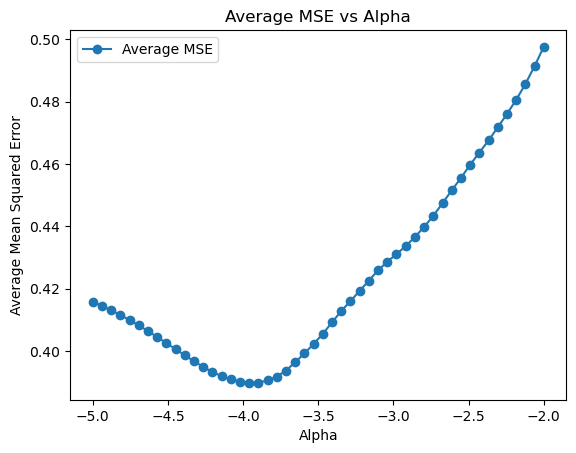

In [304]:
# Calculate the average MSE for each alpha
average_mse_dict = {alpha: np.mean(mse_values) for alpha, mse_values in mse_dict.items()}

# Plot the average MSE vs alpha
plt.plot(np.log10(list(average_mse_dict.keys())), list(average_mse_dict.values()), marker='o', linestyle='-', label='Average MSE')
plt.xlabel('Alpha')
plt.ylabel('Average Mean Squared Error')
plt.title('Average MSE vs Alpha')
plt.legend()
plt.savefig('MSE vs Alpha.png')
plt.show()


In [8]:
average_mse_df = pd.read_csv(r'C:\Users\tyler\OneDrive\Desktop\PhD Stuff\STA 6366\Final Project\Code\lasso_and_MSE.csv')

In [11]:
print(average_mse_df.loc[average_mse_df['Average MSE']==average_mse_df['Average MSE'].min(),:])

      Alpha  Average MSE
17  0.00011     0.389799


In [13]:
min_mse_alpha=0.00010985411419875583

In [16]:
stats, X_train, X_holdout, y_train, y_holdout = next(envGen)

Found cached folds, using those


In [17]:
lasso_model_final = Lasso(alpha=min_mse_alpha)
lasso_model_final.fit(X_train, y_train)

Lasso(alpha=0.00010985411419875583)

In [23]:
coefs_df = pd.DataFrame({'Feature': data_columns, 'Coefficient': lasso_coefs})

In [28]:
coefs_df.to_parquet('AllCoefficients.parquet', engine = 'fastparquet')

In [24]:
coefs_df_filtered = coefs_df[coefs_df['Coefficient'] != 0]

In [ ]:
coefs_df_filtered_sorted = coefs_df_filtered.reindex(coefs_df_filtered['Coefficient'].sort_values(ascending=False).index)

In [30]:
coefs_df_filtered_sorted.to_parquet('ImportantFeatures.parquet', engine = 'fastparquet')

In [31]:
#Filter dev and pub to see which features have importance outside of those
coefs_df_filtered_sorted_filtered = coefs_df_filtered_sorted[~coefs_df_filtered_sorted['Feature'].str.contains('dev_|pub_')]
print(coefs_df_filtered_sorted_filtered)

                                Feature  Coefficient
1519                  tag_Voice Control     0.834572
1240                        tag_Archery     0.687734
1254                           tag_Pool     0.537271
1563                      ln.curatorsp1     0.472548
778                          tag_Tennis     0.399504
...                                 ...          ...
1271                     tag_Werewolves    -0.618809
1320                           tag_Snow    -0.748576
68             Profile Features Limited    -0.993886
116                    tag_Free to Play    -1.346809
803   Steam is learning about this game    -1.470896

[368 rows x 2 columns]


In [32]:
coefs_df_filtered_sorted_filtered.to_parquet('NoPubDevFeatures.parquet', engine = 'fastparquet')